#### Analyzing Traveler Experiences

In [1]:
from IPython.display import Image
import requests
from bs4 import BeautifulSoup
import pandas as pd
from spacy.lang.en import English
import string
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import plotly.graph_objects as go

# 
<div class="alert alert-block alert-info" style="margin-top: 20px" color= 'cyan'>Customer satisfaction levels</div>

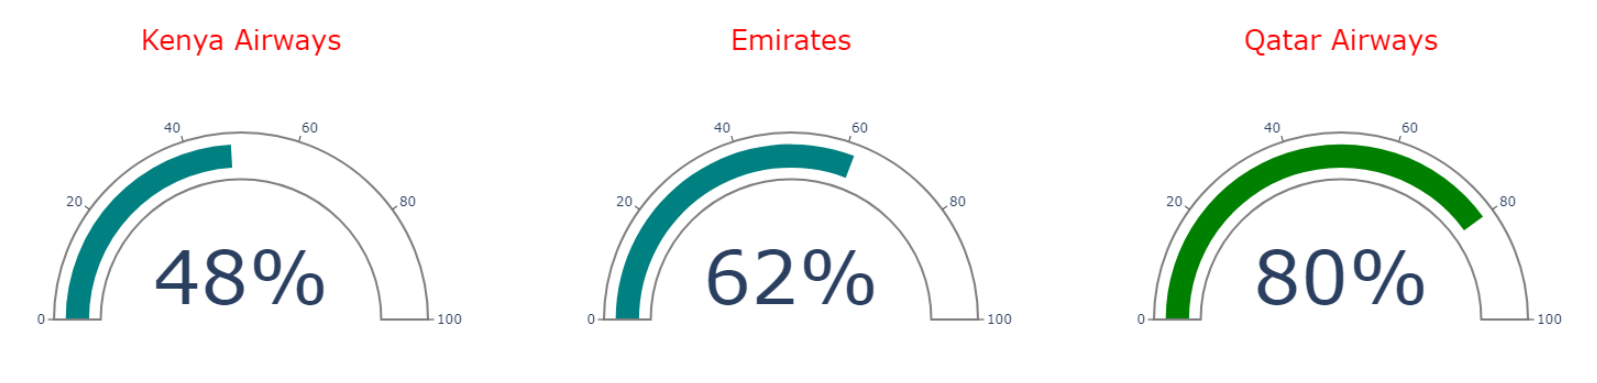

In [2]:
image_path = 'all.png'  
display(Image(filename=image_path))

Data is being scraped from [skytrax](https://www.airlinequality.com/airline-reviews/kenya-airways)

#### Data Scraping
The scraped data pertains to Kenya Airways, but the code can adapt for any airline's reviews too.

In [3]:
base_url = "https://www.airlinequality.com/airline-reviews/kenya-airways"
# base_url = "https://www.airlinequality.com/airline-reviews/emirates"
# base_url = "https://www.airlinequality.com/airline-reviews/qatar-airways"

pages = 10
page_size = 1000

reviews = []

for i in range(1, pages + 1):

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

In [4]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head(1)

,reviews
0,✅ Trip Verified | It is truly distressing for...


#### Remove unverified reviews
since the dataset is small, we'll proceed without this step.

In [5]:
# filter the rows that are Trip Verified
# df = df[df['reviews'].str.contains('Trip Verified')]
# df.size

#### Data cleaning

In [6]:
# Remove the string "Trip Verified" and "Not Verified" from the "words" column of the DataFrame
df['reviews'] = df['reviews'].str.replace('Trip Verified', '')
df['reviews'] = df['reviews'].str.replace('Not Verified', '')
# Remove the ✅ and | characters 
df['reviews'] = df['reviews'].str.replace('[✅|]', '', regex=True)
df.head(3)

,reviews
0,It is truly distressing for such a large c...
1,Dreadful airline - after emailing customer...
2,The lady at check-in was very rude and insi...


#### Tokenization

In [7]:
nlp = English()

def tokenize_text(text):
    return [token.text for token in nlp(text)]

tokenized_list = [word for review in  df['reviews'] for word in tokenize_text(review)]
print("Number of tokenized words:", len(tokenized_list))

Number of tokenized words: 73022


#### Removing stopwords

In [8]:
filtered_tokens = []

characters = string.punctuation + "—" + "." + "," + "_" + "(" + ")" + "flight" + "Kenya" + "Airways" + \
                "flights" + "fly" + "NBO" + "airline" + "KQ"

for word in tokenized_list:
    lexeme = nlp.vocab[word]
    if not lexeme.is_stop and word not in characters and word.strip() != "":
        filtered_tokens.append(word) 
print("Number of words after removing stopwords:", len(filtered_tokens))

Number of words after removing stopwords: 28202


#### Word counts

In [9]:
word_counts = Counter(filtered_tokens)
words_df = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Count'])
words_df = words_df.sort_values(by='Count', ascending=False).head(20)
words_df.head(1)

,Word,Count
198,Nairobi,533


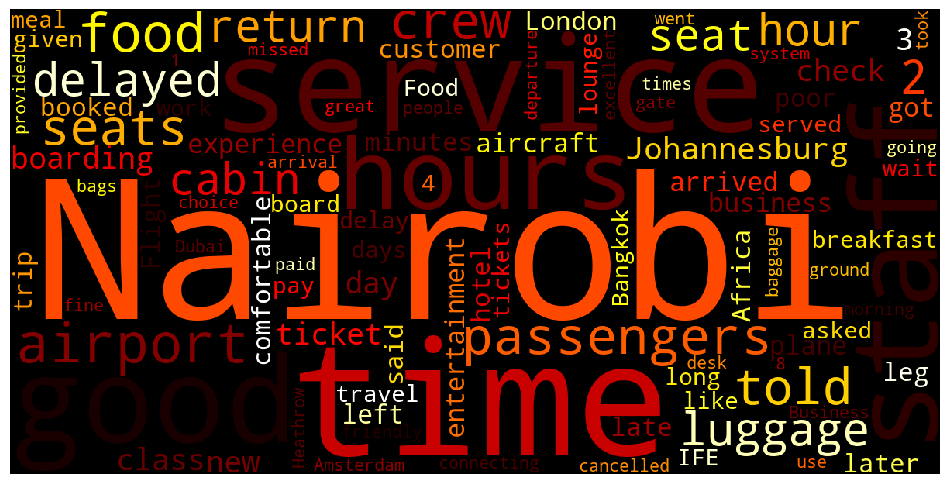

In [10]:
word_dict = dict(word_counts)
wordcloud = WordCloud(width=1200,height=600, max_words = 100, background_color='black', colormap='hot').generate_from_frequencies(word_dict)

plt.figure(figsize=(12, 8))  # Set the figure size
plt.imshow(wordcloud, interpolation="nearest")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

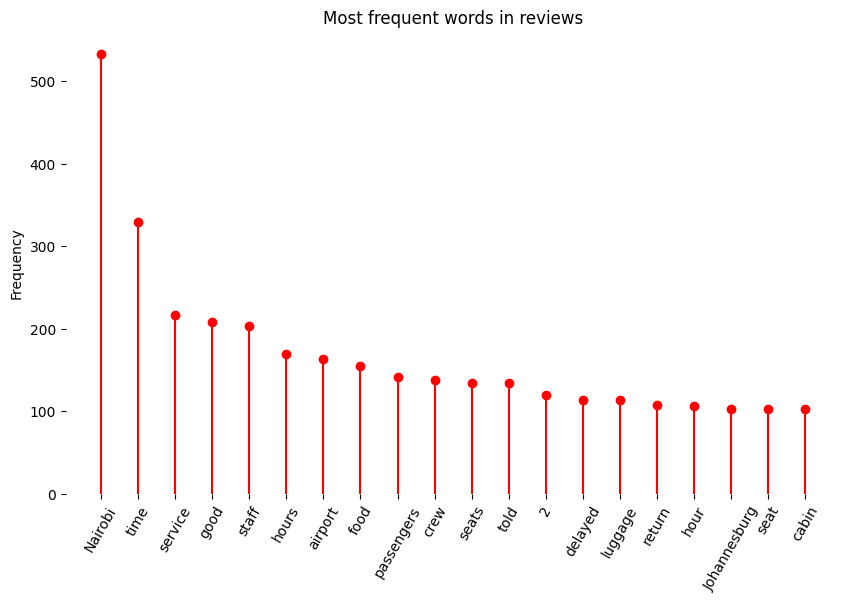

In [11]:
fig, axes = plt.subplots(figsize=(10,6))

axes.stem(words_df['Word'], words_df['Count'], basefmt=' ', linefmt='r-')
axes.set_ylim(0)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.title('Most frequent words in reviews')
plt.ylabel('Frequency')
plt.xticks(words_df['Word'],rotation=60)
plt.show()

Words like time, service, good, staff, hours, food, delayed and luggage suggest active discussions and feedback sharing, primarily centered on service quality and staff behavior.

#### Sentiment analysis

In [12]:
analyzer = SentimentIntensityAnalyzer()

def perform_sentiment_analysis(text):
    sentiment_score = analyzer.polarity_scores(text)
    return sentiment_score['compound']

df['sentiment_score'] = df['reviews'].apply(perform_sentiment_analysis)

def classify_sentiment(sentiment_score):
    if sentiment_score > 0:
        return 'Positive'
    elif sentiment_score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['sentiment_score'].apply(classify_sentiment)

In [13]:
positive_count = df[df['sentiment_label'] == 'Positive'].shape[0]
negative_count = df[df['sentiment_label'] == 'Negative'].shape[0]
total = positive_count + negative_count

positive_percentage = (positive_count / total) * 100
negative_percentage = (negative_count / total) * 100

fig = go.Figure(go.Indicator(
    mode="gauge+number",
    value=positive_percentage,  
    domain={'x': [0, 1], 'y': [0, 1]},
    gauge={'axis': {'range': [0, 100]},  
           'bar': {'color': "green"},
           'bgcolor': "white",
           'borderwidth': 2,
           'bordercolor': "gray"},
           number={'suffix': "%", 'valueformat': '.0f'}))

fig.update_layout(
    title={
        'text': "Kenya Airways",
        'x': 0.5,  
        'font': {'color': "red", 'size': 25} 
    },
    width=500,
    height=400
)
fig.show()

In [14]:
print(f"Out of {total} reviews, {positive_count} were positive and {negative_count} were negative.")

Out of 436 reviews, 210 were positive and 226 were negative.


In [ ]:
import session_info

session_info.show()
